# Tutorial III: Handwritten digit recognition

<p>
Bern Winter School on Machine Learning, 28.01-01.02 2019<br>
Mykhailo Vladymyrov
</p>

This work is licensed under a <a href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

In this session we will create a fully-connected neural network to perform handwritten digit recognition using Tensorflow

## download libraries

In [1]:
! wget http://scits-training.unibe.ch/data/tut_files/t3.tgz
! tar -xvzf t3.tgz

Der Befehl "wget" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.
tar: Error opening archive: Failed to open 't3.tgz'


## 1. Load necessary libraries

In [2]:
import sys

import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipyd
import tensorflow as tf
import tensorflow.examples.tutorials.mnist.input_data as input_data 

# We'll tell matplotlib to inline any drawn figures like so:
%matplotlib inline
plt.style.use('ggplot')
from utils import gr_disp

from IPython.core.display import HTML
HTML("""<style> .rendered_html code { 
    padding: 2px 5px;
    color: #0000aa;
    background-color: #cccccc;
} </style>""")

ModuleNotFoundError: No module named 'utils'

### 1.1. A bit of things

The training as we saw in 1st seminar is done iteratively, by adjusting the model parameters.

We perform optimization several times for all traininng dataset. Going through all this dataset is refered to as 'epoch'.

When we do training its usually done in two loops. In outer loop we iterate over all epochs. For each epoch we usually split the dataset into small chuncks, 'mini-batches', and optimization it performed for all of those.

It is important that data doesn't go to the training pipeline in same order. So the overall scheme looks like this (pseudocode):


```
x,y = get_training_data()
for epoch in range(number_epochs):
   x_shfl,y_shfl = shuffle(x,y)
   
   for mb_idx in range(number_minibatches_in_batch):
       x_mb,y_mb = get_minibatch(x_shfl,y_shfl, mb_idx)
       
       optimize_on(data=x_mb, labels=y_mb)
```

Shuffling can be easily done using permuted indexes.

In [3]:
#some array
arr = np.array([110,111,112,113,114,115,116])

#we can get sub-array for a set of indexes, eg:
idx_1_3 = [1,3]
sub_arr_1_3 = arr[idx_1_3]
print (arr,'[',idx_1_3,']','->', sub_arr_1_3)

[110 111 112 113 114 115 116] [ [1, 3] ] -> [111 113]


In [4]:
ordered_idx = np.arange(7)
permuteded_idx = np.random.permutation(7)
print(ordered_idx)
print(permuteded_idx)

permuted_arr = arr[permuteded_idx]
print (arr,'[',permuteded_idx,']','->', permuted_arr)



[0 1 2 3 4 5 6]
[6 2 4 0 5 1 3]
[110 111 112 113 114 115 116] [ [6 2 4 0 5 1 3] ] -> [116 112 114 110 115 111 113]


Some additional np things in this seminar:

In [5]:
#index of element with highest value
np.argmax(permuted_arr)

0

In [6]:
arr2d = np.array([[0,1],[2,3]])
print(arr2d)

[[0 1]
 [2 3]]


In [7]:
#flatten
arr_flat = arr2d.flatten()
#reshape
arr_4 = arr2d.reshape((4))
arr_4_1 = arr2d.reshape((4,1))

print (arr_flat)
print (arr_4)
print (arr_4_1)

[0 1 2 3]
[0 1 2 3]
[[0]
 [1]
 [2]
 [3]]


## 2. Loat the data

First we will load the data: 55000 training images and 100000 images for validation.

In [8]:
ds = input_data.read_data_sets('MNIST_data/', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

In [9]:
Xs = ds.train.images
Ys = ds.train.labels
Xs_test = ds.test.images
Ys_test = ds.test.labels
Xs_valid = ds.validation.images
Ys_valid = ds.validation.labels

print ('train: data shape', Xs.shape, 'label shape', Ys.shape)
print ('validation: data shape', Xs_valid.shape, 'label shape', Ys_valid.shape)
print ('test: data shape', Xs_test.shape, 'label shape', Ys_test.shape)

train: data shape (55000, 784) label shape (55000, 10)
validation: data shape (5000, 784) label shape (5000, 10)
test: data shape (10000, 784) label shape (10000, 10)


Let's check the images. Each image is a 28x28 pixels, but is stores as an 1D array of 784 element. So to visualize it we first reashpe it. The labes are in so-called one hot encoding: each label is a vector of length 10, with all elements equal to 0, except, corresponding to the number written in the image. Let's take a look:

In [10]:
def get_image(flatimg):
    return flatimg.reshape(28, 28)

In [11]:
img = get_image(Xs[0])
lbl = np.argmax(Ys[0])

one-hot label: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] . Actual label: 7


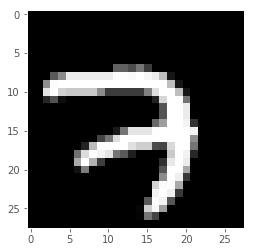

In [12]:
plt.imshow(img, cmap='gray', interpolation='nearest')
plt.grid(False)
print('one-hot label:',Ys[0], '. Actual label:', np.argmax(Ys[0]) )

In [13]:
imgs = [get_image(im) for im in Xs[0:25]]

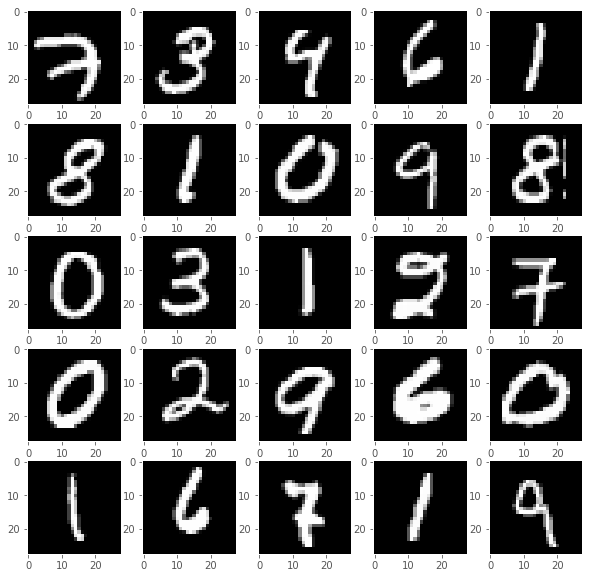

In [14]:
fig, axs = plt.subplots(5, 5, figsize=(10,10))
for idx, im in enumerate(imgs):
    y_idx = idx // 5
    x_idx = idx % 5
    axs[y_idx][x_idx].imshow(im, cmap='gray', interpolation='nearest')
    axs[y_idx][x_idx].grid(False)
plt.show()

## 3. Bulding blocks of a neural network

Neural network consists of layers of neurons. Each neuron perfroms 2 operations.
1. Calculate the linear transformation of the input vector $\bar x$: 
$$z = \bar W \cdot \bar x + b = \sum {W_i x_i} + b$$ where $\bar W$ is vector of weights and $b$ - bias.
2. Perform the nonlinear transformation of the result using activation function $f$ $$y = f(z)$$ Here we will use rectified linear unit activation.

In a fully connected neural network each layer is a set of N neurons, performing different transformations of all the same layer's inputs $\bar x = [x_i]$ producing output vector $\bar y = [y_j]_{i=1..N}$: $$y_j = f(\bar W_j \cdot \bar x + b_j)$$

Since output of each layer forms input of next layer, one can write for layer $l$: $$x^l_j = f(\bar W^l_j \cdot \bar x^{l-1} + b^l_j)$$ where $\bar x^0$ is network's input vactor.

To simplify building the network, we'll define a helper function, creating neuron layer with given number of outputs:

In [15]:
def fully_connected_layer(x, n_output, name=None, activation=None):
    """Fully connected layer.

    Parameters
    ----------
    x : tf.Tensor
        Input tensor to connect
    n_output : int
        Number of output neurons
    name : None, optional
        TF Scope to apply
    activation : None, optional
        Non-linear activation function

    Returns
    -------
    h, W : tf.Tensor, tf.Tensor
        Output of the fully connected layer and the weight matrix
    """
    if len(x.get_shape()) != 2:
        x = flatten(x, reuse=None)

    n_input = x.get_shape().as_list()[1]

    with tf.variable_scope(name or "fc", reuse=None):
        W = tf.get_variable(
            name='W',
            shape=[n_input, n_output],
            dtype=tf.float32,
            initializer=tf.contrib.layers.xavier_initializer())

        b = tf.get_variable(
            name='b',
            shape=[n_output],
            dtype=tf.float32,
            initializer=tf.constant_initializer(0.0))

        h = tf.nn.bias_add(
            name='h',
            value=tf.matmul(x, W),
            bias=b)

        if activation:
            h = activation(h)

        return h, W

In the case of classification, in the the last layer we use *softmax* transformation as non-linear transformation: $$y_i = \sigma(\bar z)_i = \frac{ e^{z_i}}{\sum_j e^{z_j}}$$

This will correspond to the one-hot labels that we use.
Finally we will use the cross entropy as the loss function: $$H(Y_{pred}, Y_{true}) = - \sum_i Y_{true, i} \log(Y_{pred, i})$$

## 4. Bulding a neural network

Number of input neurons will be given by input data, i.e. image, size. Output - by number of classes, 10 in our case.

In [16]:
n_input = Xs.shape[1]
n_output = Ys.shape[1]

In [17]:
type(n_input)

int

Lets first build a most simple network, with just 1 layer.

In [ ]:
g = tf.Graph()
with g.as_default():
    X = tf.placeholder(name='X', dtype=tf.float32, shape=[None, n_input])
    Y = tf.placeholder(name='Y', dtype=tf.float32, shape=[None, n_output])
    
    #1 layer: 784 inputs -> 10, softmax activation
    L1, W1 = fully_connected_layer(X , 10, 'L1')
    Y_onehot = tf.nn.softmax(L1, name='Logits')
    
    #prediction: onehot->integer
    Y_pred = tf.argmax(Y_onehot, axis=1, name='YPred')
    
    #cross_entropy = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(Y_onehot), reduction_indices=[1]))
    #better use same but numerically stable:
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=L1, labels=Y)
    optimizer = tf.train.AdamOptimizer(learning_rate=0.003).minimize(cross_entropy)
    
    #get fraction of correctly assigned labels
    Y_true = tf.argmax(Y, 1)
    Correct = tf.equal(Y_true, Y_pred, name='CorrectY')
    Accuracy = tf.reduce_mean(tf.cast(Correct, dtype=tf.float32), name='Accuracy')

In [ ]:
with tf.Session(graph=g) as sess:
    acc_val = []
    acc_trn = []
    
    sess.run(tf.global_variables_initializer())

    # Now actually do some training:
    mini_batch_size = 64
    n_epochs = 5
    for epoch_i in range(n_epochs):
        for mb_idx in range(ds.train.num_examples // mini_batch_size):
            x_batch, y_batch = ds.train.next_batch(mini_batch_size) #get minibatch
            sess.run(optimizer, feed_dict={
                X: x_batch,
                Y: y_batch
            })
            

        acr_v = sess.run(Accuracy,
                       feed_dict={
                           X: Xs_valid,
                           Y: Ys_valid
                       })
        acr_t = sess.run(Accuracy,
                       feed_dict={
                           X: Xs,
                           Y: Ys
                       })
        print(acr_t, acr_v)
        
        acc_val.append(acr_v)
        acc_trn.append(acr_t)

    # Print final test accuracy:
    corr, accr = sess.run((Correct, Accuracy),
                   feed_dict={
                       X: Xs_test,
                       Y: Ys_test
                   })
    
    
    #get index of first incorrectly recognize digit and display it
    wrong_idx  = [i for i,c in enumerate(corr) if c == False]
    wrong_idx0 = wrong_idx[0]
    wrong0_lbl = sess.run(Y_pred,
                   feed_dict={
                       X: Xs_test[wrong_idx0:wrong_idx0+1],
                       Y: Ys_test[wrong_idx0:wrong_idx0+1]
                   })[0]
    
    #store final value of the W1
    W1_res = sess.run(W1)
    
    fig, axs = plt.subplots(1, 2, figsize=(10,5))
    axs[0].plot(acc_trn)
    axs[0].plot(acc_val)
    axs[0].legend(('training accuracy', 'validation accuracy'), loc='lower right')
    axs[1].imshow(get_image(Xs_test[wrong_idx0]), cmap='gray', interpolation='nearest')
    axs[1].grid(False)
    plt.show()
    print('found label:',wrong0_lbl, 'true label:', np.argmax(Ys_test[wrong_idx0])  )

Let's visualize the trained weights:

In [ ]:
W1_res = W1_res.reshape(28,28,10)
_, axs = plt.subplots(1, 10, figsize=(13,5))
for i in range(10):
    axs[i].imshow(W1_res[..., i], cmap='plasma', interpolation='nearest')
    axs[i].grid(False)
    axs[i].axis('off')

Here we classify images into 10 classes. But think of it: does the network know, or need to know it's images? For the network each image is just a 784 floats. And it finds that there is a patten in those!

Same way one can feed any other bunch of numbers, and the network will try it's best to fugure out a relation pannern between those.

## 5. Excercise 1

Build a network with two layers, first with `tf.nn.relu` ReLU activation and 1500 neurons and second one with 10 and softmax activation. Start with `learning_rate` of 0.001 and find optimal value.

In [ ]:
... #1. create graph
with g.as_default():
    X = tf.placeholder(name='X', dtype=tf.float32, shape=[None, n_input])
    Y = ... #2. create labels placeholder
    
    L1, W1 = ... #3. first layer: takes X as input, 1500, relu
    L2, W2 = ... #4. second layer, 10 neurons, NO ACTIVATION HERE
    
    Y_onehot = tf.nn.softmax(L2, name='Logits')
    Y_pred = tf.argmax(Y_onehot, axis=1, name='YPred')
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=L2, labels=Y)
    optimizer = ... #5. create optimizer
    
    Y_true = tf.argmax(Y, 1)
    Correct = ... #6. correct labels mask and accuracy as mean value of mask
    Accuracy = ...
    
    # for visualization we wil calculate the gradients
    #gradients of each of 10 outputs over input x
    yh_grad = [tf.gradients(Y_onehot[..., i], X) for i in range(10)]
    #gradient of maximal output over input x
    ym_grad = tf.gradients(tf.reduce_max(Y_onehot, axis=1), X)

In [ ]:
with tf.Session(graph=g) as sess:
    ... #7. initialize global variables
    
    acc_val = []
    acc_trn = []

    mini_batch_size = 64
    n_epochs = 5
    for epoch_i in range(n_epochs):
        for mb_idx in range(ds.train.num_examples // mini_batch_size):
            x_batch, y_batch = ds.train.next_batch(mini_batch_size)
            ... #8. run the optimizer
        
        acr_v = sess.run(Accuracy,
                       feed_dict={
                           X: Xs_valid,
                           Y: Ys_valid
                       })
        acr_t = sess.run(Accuracy,
                       feed_dict={
                           X: Xs,
                           Y: Ys
                       })
        print(acr_t, acr_v)
        acc_trn.append(acr_t)
        acc_val.append(acr_v)
        
    #save also the gradients:
    yh_grad_res, ym_grad_res = sess.run((yh_grad, ym_grad), feed_dict={X: Xs_test})
    

    # Print final test accuracy:
    print('final test accuracy: ', sess.run(Accuracy,
                   feed_dict={
                       X: Xs_test,
                       Y: Ys_test
                   }))
    
    plt.plot(acc_trn)
    plt.plot(acc_val)
    plt.legend(('training accuracy', 'validation accuracy'), loc='lower right')
    

## 6. Gradients visualization

We will display several images, and corresponding gradients of maximal output activation, as well as all activations. This might help better understand how our network processes the imput data.

In [ ]:
grad = np.asarray(yh_grad_res)
grad = grad.reshape(grad.shape[0], grad.shape[2], 28,28)
gradm = np.asarray(ym_grad_res[0])
gradm = gradm.reshape(gradm.shape[0], 28,28)

n_img_d = 10
_, axs = plt.subplots(n_img_d, 12, figsize=(15,17./12*n_img_d))
for i in range(n_img_d):
    axs[i, 0].imshow(get_image(Xs_test[i]), cmap='gray', interpolation='nearest')
    axs[i, 0].set_title(np.argmax(Ys_test[i]))
    axs[i, 0].grid(False)
    axs[i, 0].axis('off')

    axs[i, 1].imshow(gradm[i], cmap='seismic', interpolation='nearest')
    axs[i, 1].set_title('max grad')
    axs[i, 1].grid(False)
    axs[i, 1].axis('off')

    gmin = np.min(grad[:, i, ...])
    gmax = np.max(grad[:, i, ...])
    for j in range(10):
        axs[i,j+2].set_title(str(j))
        axs[i,j+2].imshow(grad[j, i], cmap='plasma', interpolation='nearest', vmin = gmin, vmax = gmax)
        axs[i,j+2].grid(False)
        axs[i,j+2].axis('off')

## 7. Excercise 2

Build the network with 3 or more layers. Try to get test accuracy >98.5%.
Better to copy and modify the previous code than modyfy that one: then you can compare results.
Visualize your graph with `gr_disp.show` (Remember? you need to feed in it graph definition, e.g. `my_cute_graph.as_graph_def()`)

In [ ]:
g = tf.Graph()
......
.....
...